#  Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [8]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['.']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [9]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [10]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [11]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [12]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [13]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [14]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

1996     3
5495     2
10069    4
4513     5
7172     2
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [16]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

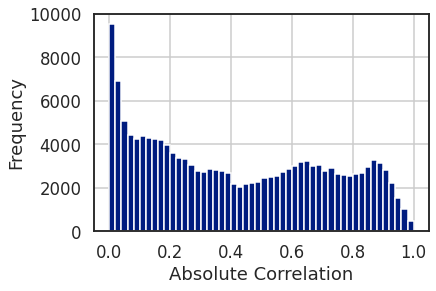

In [18]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [19]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [21]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [22]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [30]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression().fit(X_train, y_train)

In [24]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [25]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

In [26]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2').fit(X_train, y_train)

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [32]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
435 -0.004222  0.046055  0.004121 -0.058774  0.039835 -0.027015 -0.023014   
342  0.011036  0.019830  0.049216  0.021153 -0.103720  0.002485  0.000000   
402 -0.003818  0.052128  0.083261 -0.007269 -0.067423 -0.056879 -0.000257   
343 -0.005418  0.048735  0.083136 -0.032030  0.024861 -0.119284 -0.005035   
3   -0.048233 -0.210526 -0.095260 -0.304701  0.294844  0.363876  0.000000   
30   0.018765  0.079278 -0.176941  0.112220 -0.027471 -0.005851  0.000000   
307 -0.016046  0.010529  0.057410 -0.251382  0.202875 -0.003386  0.000000   
553 -0.118722  0.210628  0.074582  0.200663 -0.668185  0.301035 -0.072600   
82   0.010177 -0.080895  0.109458  0.101135  0.047874 -0.187749  0.000000   
77   0.034485 -0.307338  0.015340  0.148135  0.173800 -0.064421  0.074595   

                                                             l2            \
            1         2         3         4         5         0         1   
435  1.403227  0.000000  0.338810  0.236088  0.394001 -0.059742  0.294101   
342  0.000000  0.000000  0.600268  0.000000  0.003328  0.010727  0.029866   
402  0.674934  0.577150  0.082063  0.011613  0.117371 -0.069938  0.063547   
343  0.278228  0.121400  0.000000  0.169031  0.406654 -0.066436  0.029668   
3   -1.859305 -0.238311 -1.547447  0.000000  2.572772  0.025465 -0.379013   
30   0.000000  0.000000  0.000000 -0.102059 -2.677779  0.085797  0.147677   
307  0.000000  0.000000 -0.419718  0.475069  0.093637 -0.058558 -0.023672   
553  0.000000  0.130844  0.000000 -0.727502  0.622267 -0.170280 -0.029620   
82  -1.169163  1.311573 -0.125544  0.000000 -0.077413  0.033344 -0.572353   
77  -0.171833  0.090358  0.000000  0.636008 -0.193809  0.127811 -0.234918   

                                             
            2         3         4         5  
435 -0.301160  0.016179  0.108678 -0.058055  
342  0.054374  0.014002 -0.082005 -0.026964  
402  0.052602  0.098471 -0.031844 -0.112838  
343  0.083254 -0.004434  0.044580 -0.086632  
3   -0.006935 -0.422903  0.283286  0.500099  
30  -0.185349  0.128616 -0.113664 -0.063076  
307  0.081732 -0.310039  0.268912  0.041625  
553  0.526881  0.144222 -0.663628  0.192425  
82   0.598283  0.095476  0.046741 -0.201490  
77  -0.097747  0.086795  0.129921 -0.011862

Prepare six separate plots for each of the multi-class coefficients.

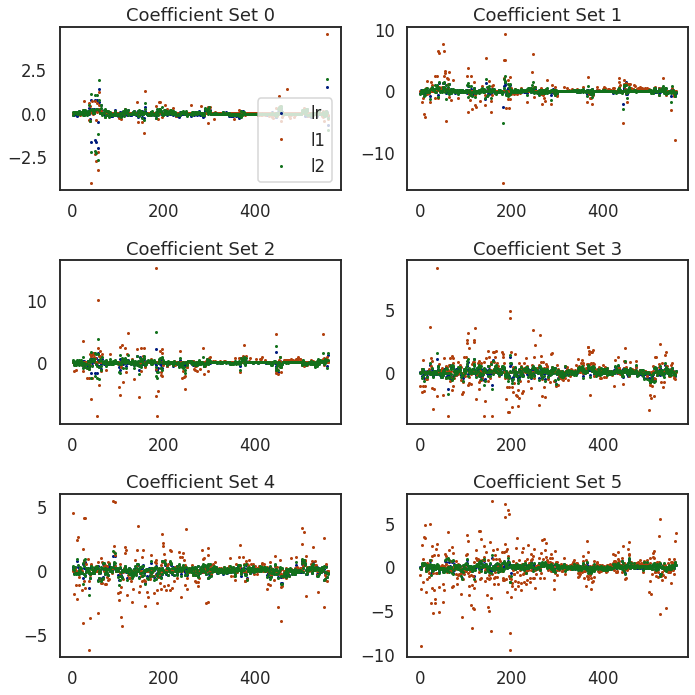

In [33]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [34]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [35]:
y_prob.head()

,lr,l1,l2
0,0.999995,0.998911,0.999997
1,0.999236,0.999631,0.999695
2,0.997411,0.995608,0.998934
3,0.988794,0.999176,0.997599
4,0.995019,0.999924,0.999342


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [37]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [38]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.980565,0.984153,0.983810
recall,0.980583,0.984142,0.983819
fscore,0.980571,0.984140,0.983811
accuracy,0.980583,0.984142,0.983819
auc,0.988238,0.990342,0.990178


## Question 8

Display or plot the confusion matrix for each model.

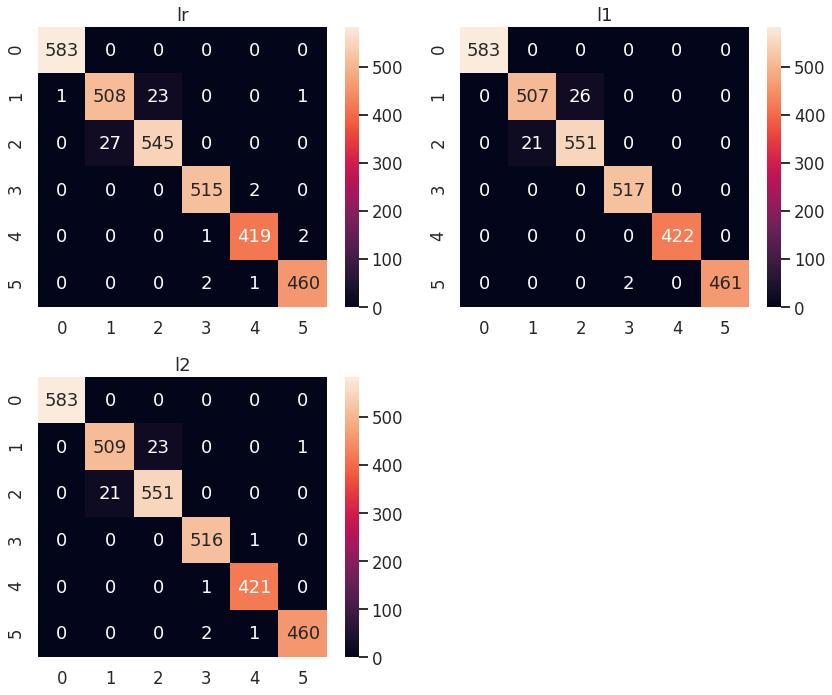

In [39]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


## Question 9
 Identify highly correlated columns and drop those columns before building models

In [87]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# from sklearn.feature_selection import VarianceThreshold

# #threshold with .7

# sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
# data2 = pd.concat([X_train,X_test])
# data_new = pd.DataFrame(sel.fit_transform(data2))


# data_y = pd.concat([y_train,y_test])

# from sklearn.model_selection import train_test_split

# X_new,X_test_new = train_test_split(data_new)
# Y_new,Y_test_new = train_test_split(data_y)


data2 = pd.read_csv(filepath, sep=',')
le = LabelEncoder()
data2['Activity'] = le.fit_transform(data2.Activity)
data2['Activity'].sample(5)

data_new = data2.iloc[:, :-1]
 
#threshold with .7
sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
data_new = pd.DataFrame(sel.fit_transform(data_new))
 
feature_cols = data_new.columns[:]
 
# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features
 
X_new = data_new.loc[train_idx, :]
Y_new = data2.loc[train_idx, 'Activity']
 
X_test_new  = data_new.loc[test_idx, :]
Y_test_new  = data2.loc[test_idx, 'Activity']

 Repeat Model building with new training data after removing higly correlated columns

In [ ]:
# Try standard, L1 and L2 Logistic regression

In [88]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression().fit(X_new, Y_new)

In [89]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', max_iter=1000).fit(X_new, Y_new)

In [90]:
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=1000).fit(X_new, Y_new)

In [ ]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [92]:
# Combine all the coefficients into a dataframe for comparison
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)


Prepare six separate plots for each of the multi-class coefficients.

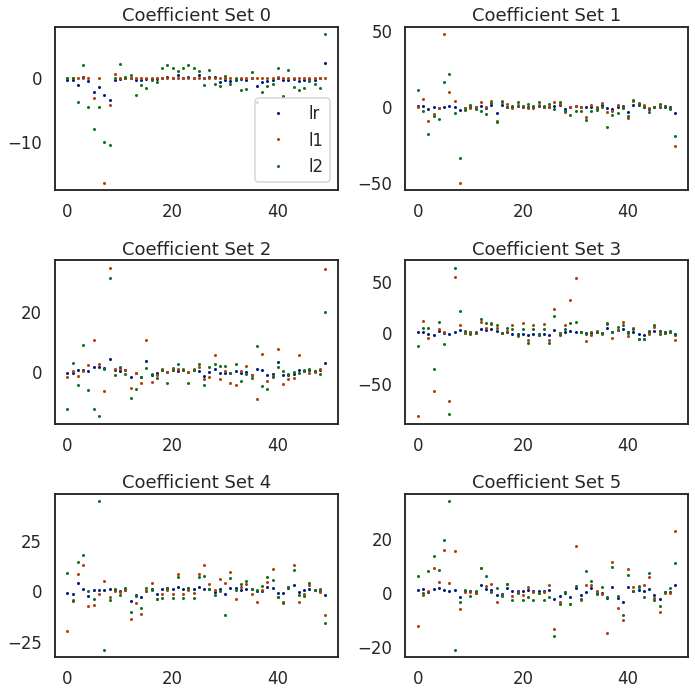

In [93]:
# try the plots
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [94]:
# Predict the class and the probability for each
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

print(y_pred.head())
print(y_prob.head())

   lr  l1  l2
0   3   3   3
1   5   5   5
2   3   3   3
3   1   1   1
4   0   0   0
         lr        l1        l2
0  0.996954  0.997247  0.999993
1  0.967242  0.998149  0.999869
2  0.988931  0.984599  0.999983
3  0.789404  0.863789  0.876145
4  0.994863  0.999995  1.000000


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [95]:
# Calculate the error metrics as listed above
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(Y_test_new, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(Y_test_new, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(Y_test_new, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(Y_test_new, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [96]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.926591,0.937335,0.937931
recall,0.926537,0.937217,0.937864
fscore,0.926514,0.937229,0.937841
accuracy,0.926537,0.937217,0.937864
auc,0.955820,0.962271,0.962729


## Question 13

Display or plot the confusion matrix for each model.

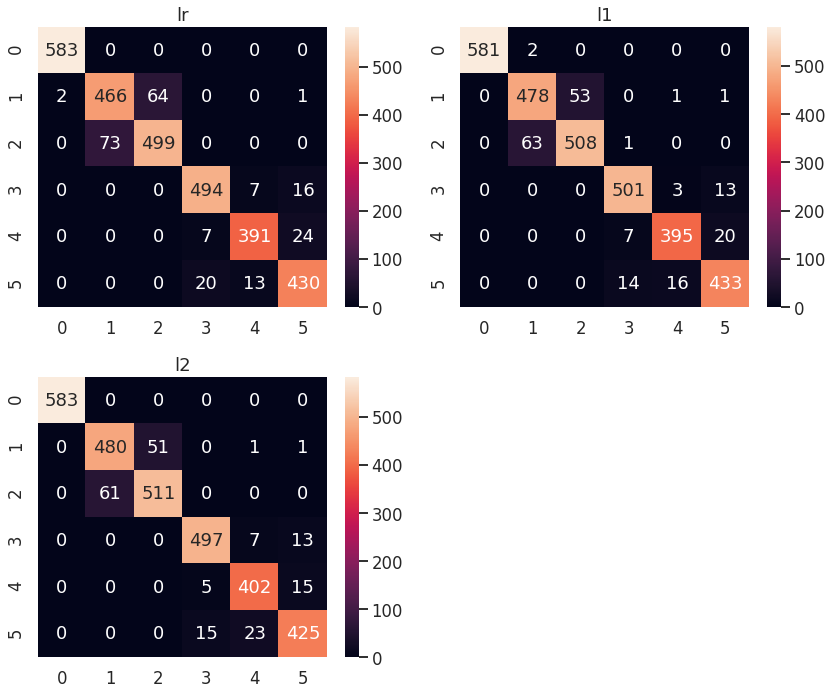

In [97]:
#plot the confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


### Perform a comparison of the outputs between Question 7 and 12 and give your observation
**Questão 7 e 12**  
Na questão 7 obtivemos valores superiores de todas as métricas sob os valores obtidos na questão 12.  

Podemos observar que os valores das métricas da questão 7 possuem valores muito altos, muito próximos a 1. Portanto existem duas possibilidades de como os modelos foram ajustados, a primeira é que o primeiro modelo poderia apresentar overfitting a segunda que não.

Multicolinearidade em regressão é uma condição que ocorre quando algumas features estão correlacionadas com outras.  A multicolinearidade forte é problemática porque pode aumentar a variância dos coeficientes de regressão, tornando-os instáveis. Dessa forma a remoção de quaisquer features altamente correlacionadas do modelo afetará significativamente os coeficientes estimados das outras features altamente correlacionados.  

Como utilizamos um threshold de variância, a multicolinearidade forte que causou a remoção de features importantes para o ajuste do modelo explicaria a redução do valor das métricas. Multicolinearidade forte implica que um modelo não conseguirá generalizar bem, isso aliado aos alto valores das métricas na questão 7, podemos dizer que existe um indicador de overfitting e que após a remoção das features altamente correlacionadas o modelo pode generalizar melhor, já que os valores obtidos na questão 12 também possuem bons valores de métricas.



### Perform a comparison of the outputs between Question 8 and 13 and give your observation

